In [1]:
# Import relevant libraries
import matplotlib.pyplot as plt
import mne
from mnelab.io import read_raw
import numpy as np
import pyxdf
import seaborn as sns
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import os

sns.set_context("paper", font_scale=1.5)


In [2]:
# Participant information and parameters of the pilot study

# Participant info
data_path = r"C:\Users\s1081686\Desktop\RA_Project\Scripts\pynt_codes\SN_pilot_data"

subjects_covert = ["pilot3",
                   "pilot4", 
                   "pilot5", 
                   "pilot6", 
                   "pilot7"]

# Experiment params
exp_params = {
'trial_time':20,
'n_trials':20,
'condition':"covert",
"code":"mgold_61_6521_mod",
"ses": "ses-S001",
"runs" : 4,
"fs": 713
}

# trial duration in samples
trial_time_samples = exp_params['fs']*exp_params['trial_time']
total_trials = exp_params['n_trials'] * exp_params ['runs']
n_chans = 6 # 6 channels in eye tracking data

In [13]:
epo_data_all_subjects = np.zeros((len(subjects_covert), total_trials, n_chans, trial_time_samples))
labels_all_subjects = np.zeros((len(subjects_covert),total_trials))

for i_sub, subject in enumerate(subjects_covert):
  epo_data_all_runs = []
  labels_all_runs = []
  print("subject", i_sub+1)
  
  for i_run in range(exp_params['runs']):
      
    print("run", i_run)
    fn = os.path.join(data_path, "raw", f"sub-{subject}", exp_params['ses'], "eeg", 
                        f"sub-{subject}_{exp_params['ses']}_task-covert_run-{1+i_run:03d}_eeg.xdf")
    
    data, header = pyxdf.load_xdf(fn)

    # get eyelink and lsl data
    streams = pyxdf.load_xdf(fn)[0]
    names = [stream["info"]["name"][0] for stream in streams]
    
    marker_stream_lsl = streams[names.index("KeyboardMarkerStream")]
    marker_stream_eyelink = streams[names.index("EyeLink")]
    
    # use labels to differentiate trials                        
    labels = [marker[3].lower().strip('""') == "right" 
    for marker in marker_stream_lsl["time_series"]
    if marker[2] == "cued_side"]
    labels_all_runs.append([1 if label else 0 for label in labels])
    
    # eyelink_data_timeseries, eyelink_data_timestamps = marker_stream_eyelink['time_series'],  marker_stream_eyelink['time_stamps']
    
    # minimal preprocessing for eyelink data
    for column in np.arange(4): # columns containing data about position        
        idx = marker_stream_eyelink['time_series'][:,column] == np.min(marker_stream_eyelink['time_series'][:,column]).astype(int)
        
        # x-coordinates
        if column ==0 or column ==2:        
            marker_stream_eyelink['time_series'][idx,column] = 1920/2
        # y coordinates
        elif column == 1 or column == 3:
            marker_stream_eyelink['time_series'][idx,column] = 1080/2
            
            
    # get epoched eyelink data across all runs
    # offsets and corrected timestamps
    offset_lsl = marker_stream_lsl['time_stamps'][0]
    offset_eyelink = marker_stream_eyelink['time_stamps'][0]

    # correct eyelink timestamps 
    eyelink_times_corr = marker_stream_eyelink['time_stamps'] - offset_eyelink

    lsl_trial_onsets = [timestamp - offset_lsl for timestamp, marker in zip(marker_stream_lsl['time_stamps'], marker_stream_lsl['time_series']) if marker[2]=='start_trial']

    # find indices of closest timestamps of eyelink stream to the lsl trial onsets
    matching_eyelink_ind = np.zeros(len(lsl_trial_onsets,))

    for index, onset_time in enumerate(lsl_trial_onsets):
        # find the difference between the lsl onsets and the eyelink timestamps
        diff_i  = np.abs(onset_time - eyelink_times_corr) 
            
        # select the eyelink timestamp index with the minimum absolute difference
        matching_eyelink_ind[index] = np.argmin(diff_i)

    matching_eyelink_ind = matching_eyelink_ind.astype(int)

        
    # find the minimum number of samples between two trial onset points:
    # using the method we have now, there is a slight irregularity in the number of samples in each trial 
    # we fix this by limiting the epoched data to a minimum number of samples (the trial with the least number of samples)

    marker_stream_eyelink['time_series'] = marker_stream_eyelink['time_series'].transpose([1,0]) # channels x samples   
    
    epo_data_run_i = np.array([[marker_stream_eyelink['time_series'][i][j:j+trial_time_samples] 
        for j in matching_eyelink_ind] for i in range(6)]).transpose([1,0,2])

    epo_data_all_runs.append(epo_data_run_i)

    
  epo_data_all_runs = np.array(epo_data_all_runs)        
  epo_data_all_runs = np.array(epo_data_all_runs).reshape(epo_data_all_runs.shape[0]*epo_data_all_runs.shape[1], epo_data_all_runs.shape[2], epo_data_all_runs.shape[3])
  labels_all_runs = np.array(labels_all_runs)
  labels_all_runs = labels_all_runs.reshape(labels_all_runs.shape[0]*labels_all_runs.shape[1],)
  
  epo_data_all_subjects[i_sub] = epo_data_all_runs 
  labels_all_subjects[i_sub] = np.array(labels_all_runs) 
  print("finished for subject", i_sub+1)

subject 1
run 0


Stream 2: Calculated effective sampling rate 732.0963 Hz is different from specified rate 1000.0000 Hz.
Stream 2: Calculated effective sampling rate 732.0963 Hz is different from specified rate 1000.0000 Hz.


run 1


Stream 2: Calculated effective sampling rate 733.5289 Hz is different from specified rate 1000.0000 Hz.
Stream 2: Calculated effective sampling rate 733.5289 Hz is different from specified rate 1000.0000 Hz.


run 2


Stream 2: Calculated effective sampling rate 730.3664 Hz is different from specified rate 1000.0000 Hz.
Stream 2: Calculated effective sampling rate 730.3664 Hz is different from specified rate 1000.0000 Hz.


run 3


Stream 3: Calculated effective sampling rate 732.1558 Hz is different from specified rate 1000.0000 Hz.
Stream 3: Calculated effective sampling rate 732.1558 Hz is different from specified rate 1000.0000 Hz.


finished for subject 1
subject 2
run 0


Stream 1: Calculated effective sampling rate 729.7797 Hz is different from specified rate 1000.0000 Hz.
Stream 1: Calculated effective sampling rate 729.7797 Hz is different from specified rate 1000.0000 Hz.


run 1


Stream 1: Calculated effective sampling rate 731.5099 Hz is different from specified rate 1000.0000 Hz.
Stream 1: Calculated effective sampling rate 731.5099 Hz is different from specified rate 1000.0000 Hz.


run 2


Stream 2: Calculated effective sampling rate 729.2208 Hz is different from specified rate 1000.0000 Hz.
Stream 2: Calculated effective sampling rate 729.2208 Hz is different from specified rate 1000.0000 Hz.


run 3


Stream 2: Calculated effective sampling rate 725.9289 Hz is different from specified rate 1000.0000 Hz.
Stream 2: Calculated effective sampling rate 725.9289 Hz is different from specified rate 1000.0000 Hz.


finished for subject 2
subject 3
run 0


Stream 1: Calculated effective sampling rate 729.9841 Hz is different from specified rate 1000.0000 Hz.
Stream 1: Calculated effective sampling rate 729.9841 Hz is different from specified rate 1000.0000 Hz.


run 1


Stream 2: Calculated effective sampling rate 726.6555 Hz is different from specified rate 1000.0000 Hz.
Stream 2: Calculated effective sampling rate 726.6555 Hz is different from specified rate 1000.0000 Hz.


run 2


Stream 2: Calculated effective sampling rate 729.7995 Hz is different from specified rate 1000.0000 Hz.
Stream 2: Calculated effective sampling rate 729.7995 Hz is different from specified rate 1000.0000 Hz.


run 3


Stream 2: Calculated effective sampling rate 729.1244 Hz is different from specified rate 1000.0000 Hz.
Stream 2: Calculated effective sampling rate 729.1244 Hz is different from specified rate 1000.0000 Hz.


finished for subject 3
subject 4
run 0


Stream 3: Calculated effective sampling rate 713.6086 Hz is different from specified rate 1000.0000 Hz.
Stream 3: Calculated effective sampling rate 713.6086 Hz is different from specified rate 1000.0000 Hz.


run 1


Stream 3: Calculated effective sampling rate 722.9057 Hz is different from specified rate 1000.0000 Hz.
Stream 3: Calculated effective sampling rate 722.9057 Hz is different from specified rate 1000.0000 Hz.


run 2


Stream 2: Calculated effective sampling rate 732.5147 Hz is different from specified rate 1000.0000 Hz.
Stream 2: Calculated effective sampling rate 732.5147 Hz is different from specified rate 1000.0000 Hz.


run 3


Stream 2: Calculated effective sampling rate 730.0668 Hz is different from specified rate 1000.0000 Hz.
Stream 2: Calculated effective sampling rate 730.0668 Hz is different from specified rate 1000.0000 Hz.


finished for subject 4
subject 5
run 0


Stream 3: Calculated effective sampling rate 730.2087 Hz is different from specified rate 1000.0000 Hz.
Stream 3: Calculated effective sampling rate 730.2087 Hz is different from specified rate 1000.0000 Hz.


run 1


Stream 3: Calculated effective sampling rate 733.3989 Hz is different from specified rate 1000.0000 Hz.
Stream 3: Calculated effective sampling rate 733.3989 Hz is different from specified rate 1000.0000 Hz.


run 2


Stream 3: Calculated effective sampling rate 729.5789 Hz is different from specified rate 1000.0000 Hz.
Stream 3: Calculated effective sampling rate 729.5789 Hz is different from specified rate 1000.0000 Hz.


run 3


Stream 3: Calculated effective sampling rate 728.9198 Hz is different from specified rate 1000.0000 Hz.
Stream 3: Calculated effective sampling rate 728.9198 Hz is different from specified rate 1000.0000 Hz.


finished for subject 5


In [14]:
print(epo_data_all_subjects.shape)
print(labels_all_subjects.shape)

(5, 80, 6, 14260)
(5, 80)


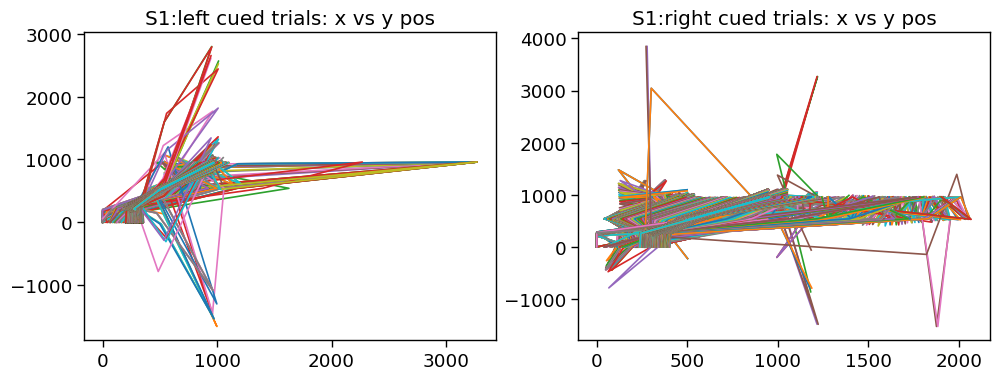

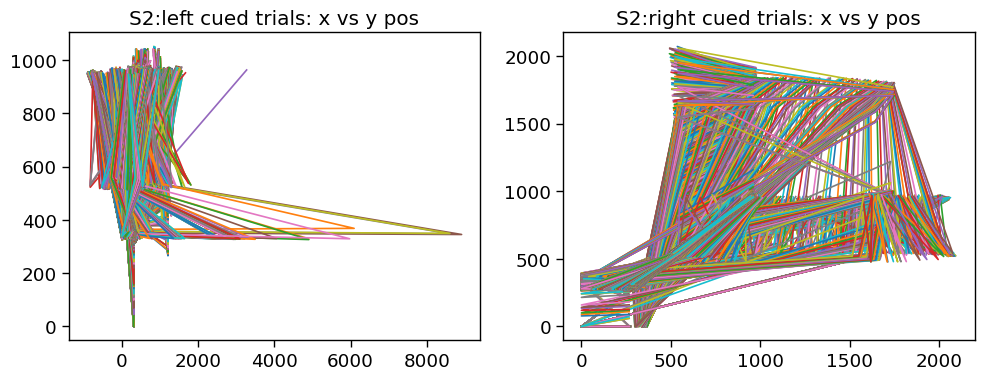

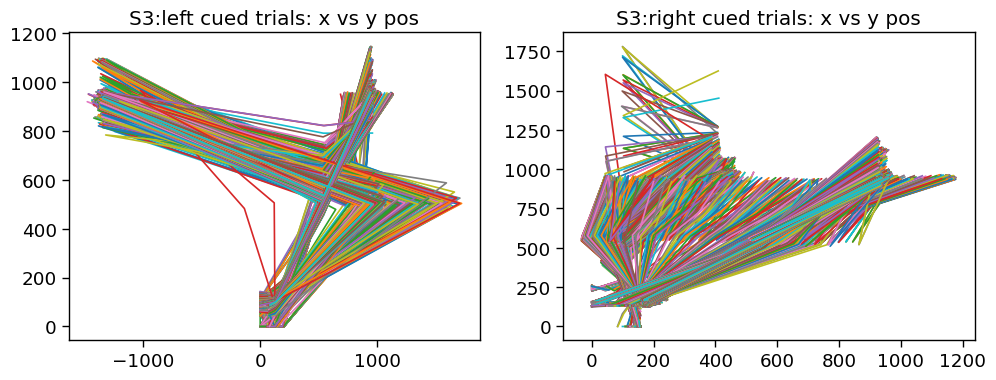

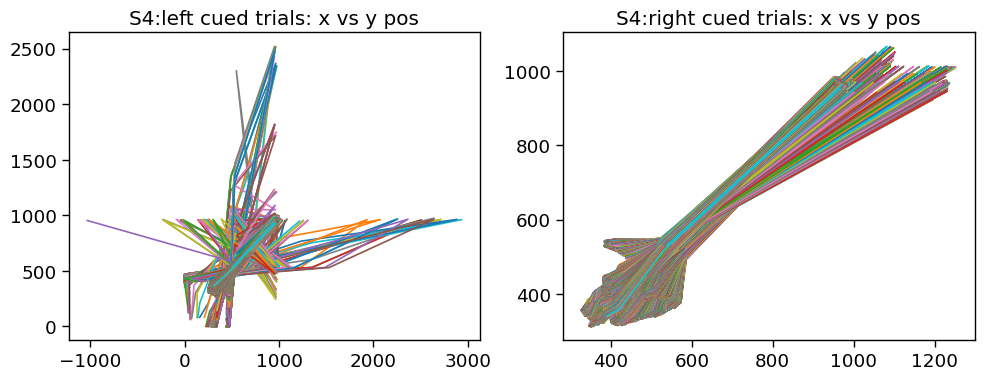

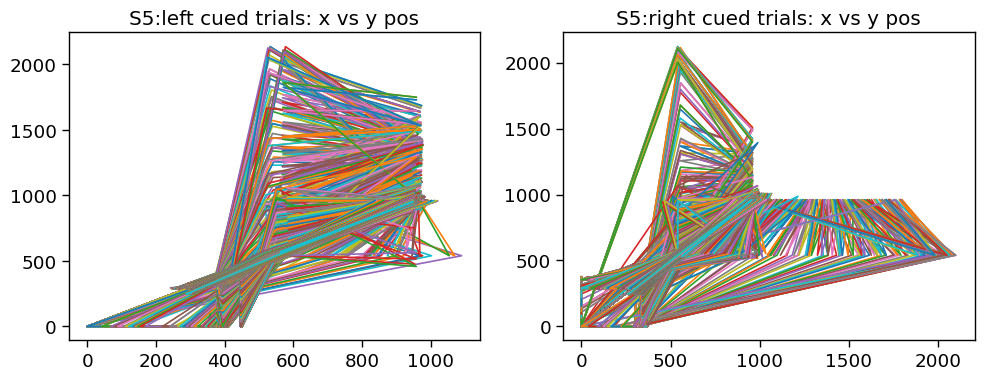

In [34]:
for i_sub in range(len(subjects_covert)):
    
    # get data
    X, y = epo_data_all_subjects[i_sub], labels_all_subjects[i_sub]
    
    # plot eye tracking data for different classes

    # pick a random run here
    data_class0 = X[np.where(y == 0)[0]]
    data_class1 = X[np.where(y == 1)[0]]

    plt.figure(figsize = (11.69,4))
    plt.subplot(121)
    plt.plot(data_class0[0],data_class0[1])
    plt.title(f'S{i_sub+1}:left cued trials: x vs y pos')

    plt.subplot(122)
    plt.plot(data_class1[0],data_class1[1])
    plt.title(f'S{i_sub+1}:right cued trials: x vs y pos')
    plt.show()

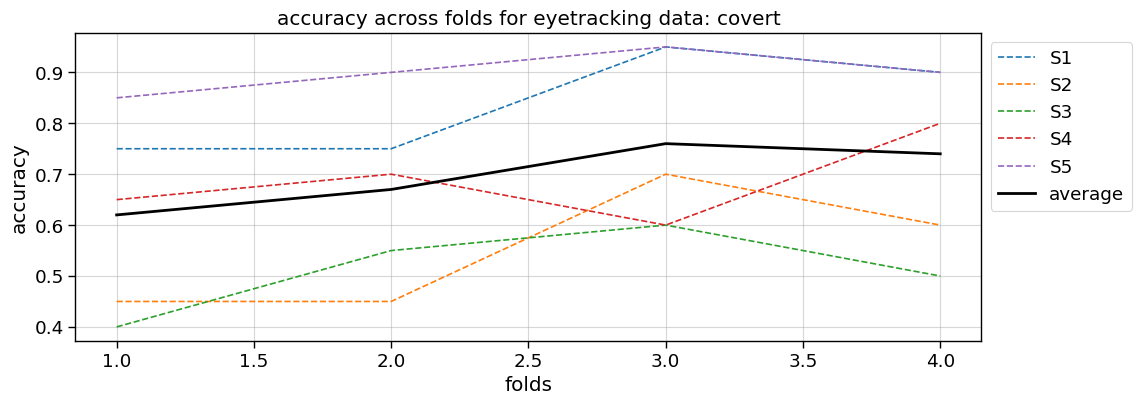

In [36]:
# fit the data to a classifier
# evaluating performance across participants
n_folds = 4
accuracy_covert = np.zeros((len(subjects_covert), n_folds)) 


for i_sub in range(len(subjects_covert)):
    X, y = epo_data_all_subjects[i_sub], labels_all_subjects[i_sub]
    
    n_trials, n_channels, n_samples = X.shape
    n_classes = len(np.unique(y))
    

    folds = np.repeat(np.arange(n_folds), int(n_trials / n_folds))

    # Loop folds
    accuracy = np.zeros(n_folds)
    for i_fold in range(n_folds):
        # Split data to train and test set
        X_trn, y_trn = X[folds != i_fold, :, :n_samples].mean(axis=2), y[folds != i_fold]
        X_tst, y_tst = X[folds == i_fold, :, :n_samples].mean(axis=2), y[folds == i_fold]

        # fit data 
        'average the time dimension, take windows'
        clf = LDA()
        clf.fit(X_trn,y_trn)

        # Apply template-matching classifier
        yh_tst = clf.predict(X_tst)

        # Compute accuracy
        accuracy[i_fold] = np.mean(yh_tst == y_tst)
        
    accuracy_covert[i_sub] = accuracy

plt.figure(figsize = (11.69,4))        
for i in range(accuracy_covert.shape[0]):
    plt.plot(np.arange(1,5),accuracy_covert[i], label =f'S{i+1}', linestyle = '--')
    
plt.plot(np.arange(1,5), accuracy_covert.mean(axis = 0), color = 'k', linewidth = 2, label = 'average')
plt.xlabel('folds')
plt.ylabel('accuracy')
plt.title('accuracy across folds for eyetracking data: covert')
plt.legend(bbox_to_anchor=(1,1))
plt.grid(alpha = 0.5)
              
              

In [33]:
accuracy_covert.mean(axis = 0).mean()

0.6975